# Programming Methodologies for Data Analysis: Group Project 

## Authors
- Lorenzo Dell'Oro
- Giovanni Toto
- Gian Luca Vriz

## 0. How to use this notebook?
Some steps of this notebook, such as corpus download, model estimation and model evaluation, may not be immediate or may require several hours to complete, hence we decide to comment those parts of code and provide directly the result as files to download.
In particular, we indicate here from where to download all the necessary files:
- use this [link](https://drive.google.com/drive/folders/1QZZq_z2VOf9knPFhR_bUvc6dKfO0Q9qh?usp=share_link) to download the `.csv` file containg the corpus and to download the `.pt` files containing the parameters of estimated models;
- use this [link](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing) to download Google’s Word2vec pre-trained word embeddings;
- use this [link](https://nlp.stanford.edu/data/glove.6B.zip) to download the 300-dimensional version of *Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download)*.

`guardian_environment.csv` must be copied in `data/raw` folder; `.pt` files in `results` folder; `GoogleNews-vectors-negative300.bin` and `glove.6B.300d.txt` in `embeddings/pretrained` folder. Obviously all files must be previously unzipped.


## 1. Introduction
Nowadays, climate change is one of the main challenges for humankind, with the potential to impact the health of nearly every person on Earth. Thus, it is a subject undergoing intense study, which requires interconnection between different academic fields. 
From this perspective, the aim of this project is to answer the question: how the concept of climate change is seen from a human standpoint?
To pursue this objective we consider for a time period of 10 years all the articles published in one of the most important British newspapers, *The Guardian*.

To pursue this objective, we are going to use two topic models which marries *Latent Dirichlet Allocation* (*LDA*; Blei at al., 2003) and word embeddings: the *Embedded Topic Model* (*ETM*) and its time-aware extension *Dynamic Embedded Topic Model* (*D-ETM*; Dieng et al., 2019). These models can estimate themselves the embedding space or they can receive as input pre-trained word embeddings and estimate the other parameters around the embedding space induced by these word embeddings. Here we are interested in the second case, hence we consider five different word embeddings (three fitted on the corpus and one pre-trained) and evaluate the quality of the topic models as they vary.

This notebook is structured as follows:
- in section 2 we introduce the dataset and the steps to pre-process it;
- in section 3 we perform *exploratory data analysis* (*EDA*);
- in section 4 we fit three word embeddings and download the other two;
- in section 5 we estimate *ETM* with varying number of topics and word embeddings;
- in section 6 we compare the models both quantitatively and qualitatively;
- in section 7 we estimate *D-ETM* with the best combination of number of topics and word embeddings according to *ETM*;
- in section 8 we draw conlusions and briefly introduce future work.

In [1]:
%load_ext autoreload
%autoreload 2

# importing libraries
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import re
import seaborn as sns
import string
import torch
import xml.etree.ElementTree

# importing functions from libraries
from collections import Counter
from gensim.models import FastText, KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from ipywidgets import fixed, interact, widgets
from sklearn.manifold import TSNE
from wordcloud import WordCloud

# importing functions from modules
from src.exploratory_analysis import most_used_words, top_authors, wordcloud_corpus
from src.file_io import save_embeddings
from src.main_DETM import main_DETM
from src.main_ETM import main_ETM
from src.model_comparison import display_metric, load_metrics
from src.preprocessing import preprocessing
from src.qualitative_analysis import barplot_topwords, visualize_documents, visualize_topics, visualize_top_words, visualize_top_words_evolution

# seaborn setting
sns.set(style='darkgrid')
# topic colors and corpus color for plots
colours = ["#006000", "#800080", "#0000FF", "#632518", "#FF8800", "#FF0000", "#F1E200", "#00AAFF", "#A7D131", "#CC6699"]
alt_colour = '#BCBCBC'

## 2. Guardian dataset
*The Guardian* is one of the most important newspapers in the United Kingdom and in the English-speaking world. Its widely recognized reputation makes it one of the most reliable sources about global issues, such as climate change.
Since the latter is one of the most discussed topic in the last years, our aim is to study what are the keywords of the related mainstream public debate and if they changed in the last decade, i.e. between 2013 and 2022.

### 2.i. Download using API
In order to obtain the best dataset according to the needs of our analysis, we downloaded the articles from [The Open Platform](https://open-platform.theguardian.com), the Guardian's official API.

We are interested in articles in English published between 01/01/2013 and 31/12/2022 in the *environment* section of *The Guardian* and containing the expression "climate change". In order to download articles with these charachteristics, we built the following query:
- `type = 'article'`, to exclude other types of content, such as video and audio files;
- `section = 'environment'`, to select only articles published in that section of  the newspaper;
- `q = '"climate change"'`, to get only the articles that contain those two words in that order;
- the date of the downloaded articles spans from `from-date = 01/01/2013` to `to-date = 31/12/2022`;
- `lang = 'en'` assures that all the selected articles are written in the same language (English), a basic request of text mining;
- `order-by`, `page-size`, `show-fields` and `api-key` are technical arguments of the query.

We need an API key in order to download the articles: in the following block, you should replace `'test'` with your API key; it can be easily obtained [here](https://open-platform.theguardian.com/access/).

In [2]:
"""
api_key = 'test'
query = {'type': 'article',
         'q': '"climate change"',
         'section': 'environment',
         'from-date': "2013-01-01",
         'to-date': "2022-12-31",
         'lang': 'en',
         'order-by': 'oldest',
         'page-size': 200,
         'show-fields': 'all',
         'api-key': api_key}

from src.file_io import download_guardian
corpus = download_guardian(query, 'data/raw/guardian_environment.csv')
"""
corpus = pd.read_csv('data/raw/guardian_environment.csv')

### 2.ii Selection of the variable of interest
`corpus` is a `pandas` dataset containing several pieces of information for each document, most of which are not relevant to our analysis; hence, we keep only the following fields:
- document-related:
    - `id`: identifier;
    - `year`: year of publication on the website (`webPublicationDate`);
    - `where`: original place where the article was published (`fields_publication`);
    - `author`: author (`fields_byline`);
- text-related:
    - `headline`: title (`fields_headline`);
    - `standfirst`: summary (`fields_standfirst`);
    - `body`: text with tags (`fields_body`);
    - `bodyText`: text without tags (`fields_bodyText`);
- count-related:
    - `wordcount`: number of words in the body (`fields_wordcount`);
    - `charcount`: number of characters in the body without tags (`fields_charcount`);
    
We report in parentheses the original name of the field or, in the case of `year`, the name of the field from which `year` was obtained.

In [3]:
col_of_interest = ['id', 'webPublicationDate', 'fields_publication', 'fields_byline',
                   'fields_headline', 'fields_standfirst', 'fields_body', 'fields_bodyText',
                   'fields_wordcount', 'fields_charCount']
# select columns of interest
corpus = corpus.loc[:, col_of_interest]
# convert 'webPublicationDate' field to year
corpus['webPublicationDate'] = pd.to_datetime(corpus['webPublicationDate']).dt.year
# rename columns
new_colnames = {'webPublicationDate': 'year', 'fields_publication': 'where', 'fields_byline': 'author',
                'fields_headline': 'headline', 'fields_standfirst': 'standfirst', 'fields_body': 'body', 'fields_bodyText':'bodyText',
                'fields_wordcount': 'wordcount', 'fields_charCount': 'charcount'}
corpus.rename(columns=new_colnames, inplace=True)

Then, we remove the articles which do not have a body, i.e. whose value of `bodyText` is `nan`.

In [4]:
corpus = corpus[corpus['bodyText'].isna() == False]

Finally, if an article's `headline` and/or `standfirst` is `nan`, we replace it with an empty string.

In [5]:
corpus['headline'][corpus['headline'].isna() == True] = ''
corpus['standfirst'][corpus['standfirst'].isna() == True] = ''

### 2.ii. Pre-processing of the texts
In this section we process the texts of the article downloaded in the previous section in order to make them compatible with *ETM* and *D-ETM*. In particular, we want to obtain two lists of strings:
- `timestamps` containing the timestamps of the articles, i.e. the years in which they were published;
- `docs` containing the processed texts of the articles, i.e. the headline, standfirst and body.

First, we obtain `timestamps` variable from `year` field:

In [6]:
timestamps = [str(y) for y in corpus['year'].tolist()]

Then, we process the texts in order to obtain an input compatible with text analysis approaches:

In [7]:
# regex for urls; source: https://stackoverflow.com/a/50790119
url_regex = r"\b((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)\b"
tag_regex = re.compile('<.*?>')

docs = corpus['headline'] + " " + corpus['standfirst'] + " " + corpus['bodyText']
docs = docs.tolist()
docs = [re.sub(url_regex, '', docs[doc]).lower() for doc in range(len(docs))]
docs = [re.sub(tag_regex, '', docs[doc]) for doc in range(len(docs))]
docs = [[w.translate(str.maketrans('', '', string.punctuation + "0123456789")) for w in docs[doc].split()] for doc in range(len(docs))]
docs = [[w for w in docs[doc] if len(w)>1] for doc in range(len(docs))]
docs = [" ".join(docs[doc]) for doc in range(len(docs))]

Finally, we use the `preprocessing` function contained in `src/preprocessing.py` module, which creates files compatible with *ETM* and *D-ETM*. Before launching the function, we need to import stopwords:

In [8]:
# Read stopwords
with open("./data/stops.txt", "r") as f:
    stopwords = f.read().split('\n')
# Pre-processing
data_path = 'data/guardian_environment'
preprocessing(data_path=data_path, docs=docs, timestamps=timestamps, stopwords=stopwords,
              min_df=50, max_df=0.7, data_split=[0.7, 0.2, 0.1], seed=28)

***************
Preparing data:


ValueError: "path_save" not valid: the folder already exists.

It is a good practice in machine learning to split our data into the following three groups:
- *training set*: for training of the model,
- *validation set*: for unbiased evaluation of the model,
- *test set*: for final evaluation of the model.

This setup helps ensuring that we have a realistic understanding of our model's performance and that we hopefully estimate a model which generalizes well to new data. The last function divides the corpus into these three sets, and we are going to use only the training set for the exploratory analyses in the next section.

## 3. Exploratory data analysis
In this section, we perform *exploratory data analysis* (*EDA*) on the dataset imported by the previous query. *EDA* is an approach to analyze data sets and to summarise their main characteristics using statistical graphics and other data visualization methods. 

Before moving on, we remove all variables that we are no longer going to use:

In [9]:
del col_of_interest, docs, new_colnames, tag_regex, url_regex

As already said, we are going to consider only the training set. Therefore, we replace the whole corpus, stored in the `corpus` variable, with the train set (the test and validation sets are useless for now). We also store the vocabulary of the train set in the `vocab` variable.

In [10]:
with open('data/guardian_environment/info.json', 'r') as f:
    info = json.load(f)
    vocab = info['vocab_tr']
    corpus = corpus.iloc[info['indices_tr'], :]
    docs_bow = [[vocab[v] for v in doc] for doc in info['docs_tr']]
    del info

docs_by_year = {}
year_list = sorted(list(set(timestamps)))
for year in year_list:
    docs_by_year[year] = [docs_bow[d] for d in range(len(docs_bow)) if timestamps[d] == year]

First, we implement a bar plot to show the repartition of articles by publication date:

In [11]:
fig = px.bar(corpus.groupby(['year'])['year'].count().reset_index(name='number of articles'), x='year', y='number of articles',
             title="Bar plot by pubblication date", labels=dict(year='year'))
fig.update_traces(marker_color='steelblue')
fig.update_traces(marker_line_width=1, marker_line_color='black')
fig.show()

The two years with the greatest number of published articles are 2015 and 2021. This trend could be the consequence of an important event in the UK's coal industry and of global effects of climate change: in 2015 the government announced that all remaining coal-fired power stations would be closed by 2025, and it was also the year in which the Paris Agreement was adopted; while, in 2021 the world was affected by an unprecedented number of extreme events due to climate change.
The least value of publications is in 2020, which coincides with the start of the Covid-19 pandemic across Europe.

The following graph presents the distribution of the articles by the number of words:

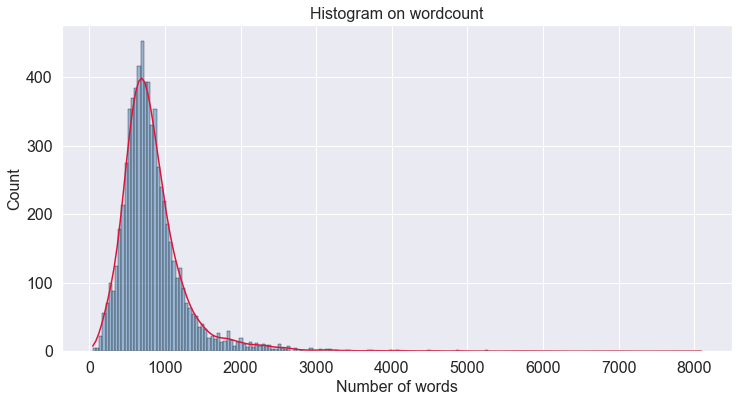

In [12]:
fig, ax = plt.subplots(figsize=(12,6)) 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
sns.histplot(data=corpus, x="wordcount", kde=True, edgecolor='black', color='steelblue')
ax.lines[0].set_color('crimson')
plt.xlabel('Number of words', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Histogram on wordcount', fontsize=16)
plt.show()

We note that the distribution presents a long-right tail, so we restrict the attention only to the articles with a number of words less than 3000 in order to have a better representation. Doing this we remove 51 documents only from the histogram:

Documents with more than 3000 words are 51


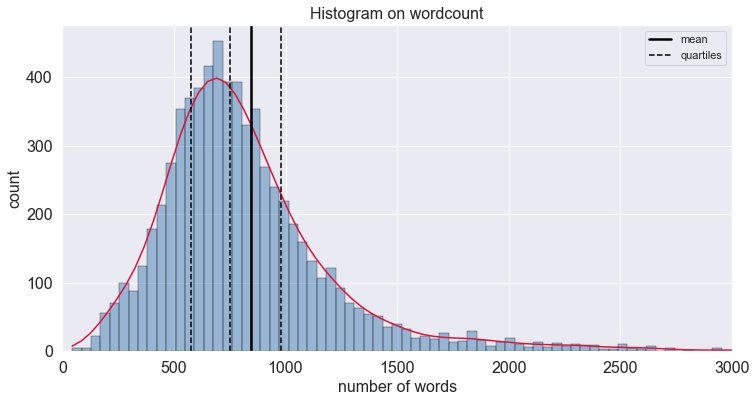

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
print('Documents with more than 3000 words are', len(corpus[corpus['wordcount'] >= 3000]))
sns.histplot(data=corpus, x='wordcount', kde=True, edgecolor='black', color='steelblue')
ax.lines[0].set_color('crimson')
plt.xlabel('number of words', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.title('Histogram on wordcount', fontsize=16)
plt.xlim(0, 3000)
m = plt.axvline(np.mean(corpus['wordcount']), linewidth=2.5, color='black', label='mean')
q_1 = plt.axvline(np.percentile(corpus['wordcount'], 25), linestyle='--', color='black', label='quartiles')
q_2 = plt.axvline(np.percentile(corpus['wordcount'], 50), linestyle='--', color='black')
q_3 = plt.axvline(np.percentile(corpus['wordcount'], 75), linestyle='--', color='black')
plt.legend(handles=[m, q_1])
plt.show()

The distribution has a mean equal to 846 words, while the median is equal to 751 and the mode is 638.
If a frequency distribution has a symmetrical frequency curve, then the mean, median and mode will be equal; however, we have a positively skewed distribution, since the mean is greater than the median and the median is greater than the mode.

All the articles can be published through three main routes: directly in *The Guardian* paper magazine, in *The Observer* sub-journal and in the online website *theguardian.com*. The division of all the articles is reported in the below pie chart:

In [14]:
fig = px.pie(corpus.groupby(['where'])['where'].count().reset_index(name='count'), values='count', names='where',
             title='Pie chart on sub-journals', hole=0.35)
fig.update_traces(textposition='outside', textinfo='percent+label',marker=dict(line=dict(color='#000000', width=4)),
                                  pull=[0.00, 0.00, 0.00], opacity=0.9)
fig.show()

With the same reasoning, all articles can be grouped by author. In the following, we show the first 15 authors by the number of publications:

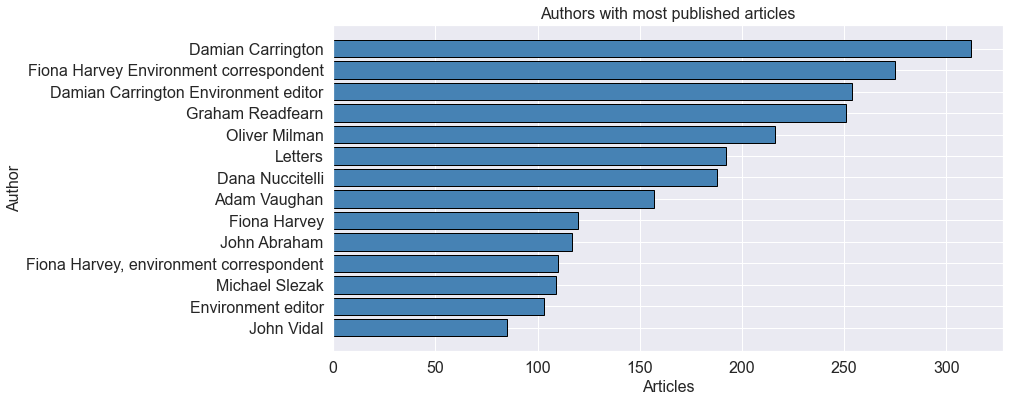

In [15]:
top_authors(corpus, 15)

 The last exploratory analysis has the aim to show the 15 most used words in the collection:

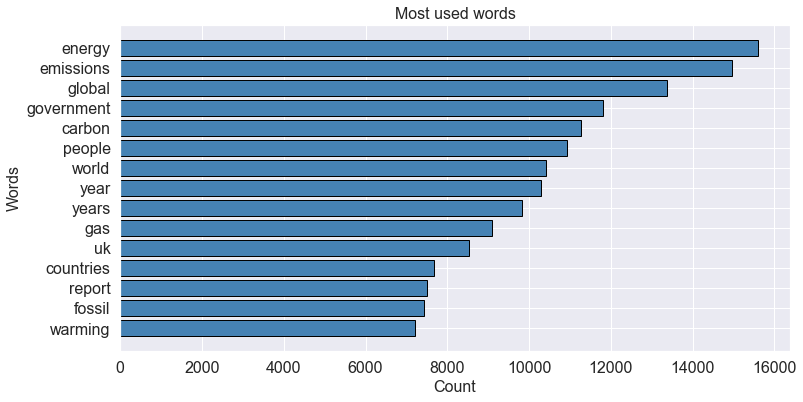

In [16]:
most_used_words(docs_bow, 15)

As can be easily predicted, they are related to the energy crisis, present and future, and how governments and countries are trying to solve it. In particular, it is interesting to note that the first five words are *energy*, *emission*, *global*, *government* and *carbon*: this could mean that the main topic in climate change from 2013 to 2022 was based on the interconnection between government policies and industry.

To have a more complete and more impactful representation of word frequencies, we report a *wordcloud* in which colours are random, while the size of each term is proportional to its term frequency:

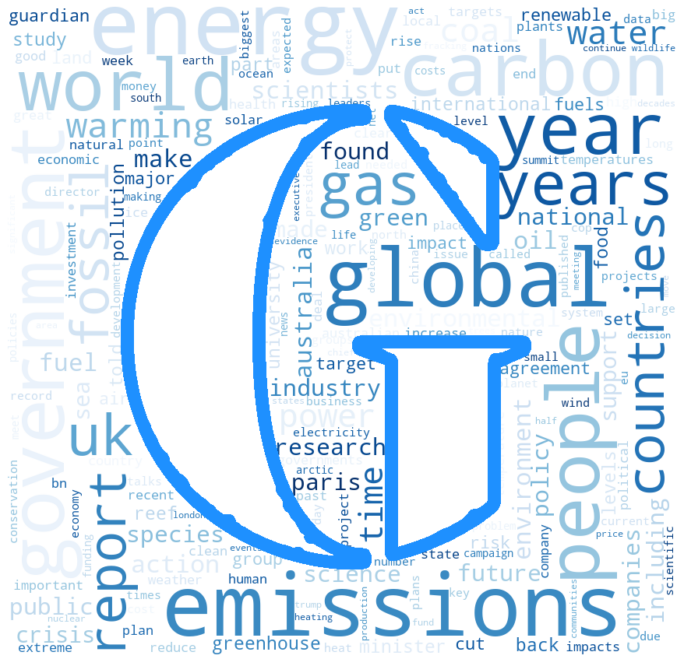

In [17]:
wordcloud_corpus(docs_bow)

Finally, we report also a *wordcloud* for each year, which considers just the articles published in the specific timeframe:

In [18]:
@widgets.interact(year=year_list)
def get_wordcloud(year):
    docs_bowf_year = [item for sublist in docs_by_year[str(year)] for item in sublist]
    docs_bowf_count_year = Counter(docs_bowf_year)

    tot_dwords_year = {}
    tot_dword_year = dict(sorted(docs_bowf_count_year.items(), key = lambda item: item[1]))

    wordcloud = WordCloud(background_color='white', contour_width=30, colormap='Blues',
                          contour_color='dodgerblue').generate_from_frequencies(tot_dword_year)

    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

interactive(children=(Dropdown(description='year', options=('2013', '2014', '2015', '2016', '2017', '2018', '2…

## 4. Word embeddings
In *Natural Language Processing* (*NLP*), a word embedding is a mathematical representation of a word. Commonly, the representation is a real-valued vector that encodes the meaning of the word with the aim that words closer to each other in the vector space are expected to be similar in meaning. 
In this section, we fit the word embeddings on which we are going to estimate the *ETM*.

We set here from where the notebook should import the pre-trained embeddings (`pretrained_folder`) and where it should save the input files for `ETM` function (`embedding_folder`):

In [19]:
embedding_folder, embedding_file = 'embeddings/', 'guardian_environment'
embedding_path = embedding_folder + embedding_file
pretrained_folder = embedding_folder + 'pretrained/'

### 4.i. Random embeddings
As a baseline, we introduce the *random embeddings*, i.e. embeddings which are initialized randomly. `ETM` function checks if the word embedding of each word is available and, if one or more of them are not, a random vector is sampled from $N(0, 0.6^2)$, i.e. a normal distribution with mean 0 and standard deviation 0.6. Hence, here we just create an empty file that will make `ETM` function sample the word embedding for each word of the vocabulary.

In [20]:
emb_file = embedding_path + '_random.txt'
if not os.path.isfile(emb_file):
    with open(emb_file, 'w') as empty_file: 
        pass

### 4.ii. Word2vec on train corpus
*Word2vec* is a group of related models that are used to produce word embeddings, created and published by a team of researchers in *Google* over two papers (Mikolov et al., 2013a, 2013b). *Word2vec* can utilize either of two model architectures to produce the word embeddings: *Continuous Bag-Of-Words* (*CBOW*) or *skip gram*. In both architectures, *word2vec* considers both individual words and a sliding window of context words:
- in the *CBOW* architecture, the model predicts the current word from the window of surrounding context words;
- in the *skip gram* architecture, the model uses the current word to predict the surrounding window of context words.

We use the `Word2Vec` function of the `gensim` library to train 300-dimensional word embeddings on the train set using *CBOW* and *skip gram* with a windows size of 10 (`window`) and 5 noise words in the negative sampling (`negative`). The models run for 10 iterations and compute the word embeddings for each word selected in the pre-processing step.

In [21]:
# sg=0: CBOW
emb_file = embedding_path + '_cbow.txt'
if not os.path.isfile(emb_file):
    cbow = Word2Vec(sentences=docs_bow, min_count=1, sg=0, size=300, iter=10, workers=5, negative=5, window=10)
    save_embeddings(emb_model=cbow, emb_file=emb_file, vocab=vocab)
    del cbow
# sg=1: skipgram
emb_file = embedding_path + '_skipgram.txt'
if not os.path.isfile(emb_file):
    skipgram = Word2Vec(sentences=docs_bow, min_count=1, sg=1, size=300, iter=10, workers=5, negative=5, window=10)
    save_embeddings(emb_model=skipgram, emb_file=emb_file, vocab=vocab)
    del skipgram

### 4.iii. FastText on train corpus
*FastText* (Bojanowski et al., 2017), which can be considered an extension of *word2vec*, treats each word as composed of character $n$-grams.
So, instead of producing the word embeddings only for complete words, the model produces the word embeddings for all the $n$-grams and then produces each word as the sum of the $n$-grams contained in it.

We use the `FastText` function of the `gensim` library to train 300-dimensional word embeddings on the train set using *FastText* with a window size of 10 (`window`) and 5 noise words in the negative sampling (`negative`). The model runs for 10 iterations and computes the word embeddings for each word selected in the pre-processing step.

In [22]:
emb_file = embedding_path + '_fasttext.txt'
if not os.path.isfile(emb_file):
    fasttext = FastText(sentences=docs_bow, min_count=1, size=300, iter=10, negative=5, window=10)
    save_embeddings(emb_model=fasttext, emb_file=emb_file, vocab=vocab)
    del fasttext

### 4.iv. Google’s Word2vec
We use the word embeddings trained on part of the Google News dataset (about 100 billion words) using a simple data-driven approach described in Mikolov et al. (2013b). The model contains 300-dimensional vectors for 3 million words and phrases; however, we just keep the ones which are in the vocabulary of the train set. You can find out more [here](https://code.google.com/archive/p/word2vec/) and use this [link](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing) to download the pre-trained word embeddings. 

First, you need to download `GoogleNews-vectors-negative300.bin.gz` using the link above, unzip it and copy `GoogleNews-vectors-negative300.bin` in `embeddings/pretrained` folder , then you can use `gensim` library to load the word embeddings and finally create the input file for `ETM` function.

In [23]:
emb_file = embedding_path + '_google_word2vec.txt'
if not os.path.isfile(emb_file):
    google_word2vec = KeyedVectors.load_word2vec_format(pretrained_folder+'GoogleNews-vectors-negative300.bin', binary=True)
    save_embeddings(emb_model=google_word2vec, emb_file=emb_file, vocab=vocab)
    del google_word2vec

### 4.v. Stanford’s GloVe
Quoting the [official website](https://nlp.stanford.edu/projects/glove/), *GloVe* (Pennington et al., 2014) is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.
There are four pre-trained word vectors available: here we use a 300-dimensional version of *Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download)*, which can be downloaded using this [link](https://nlp.stanford.edu/data/glove.6B.zip).

First, you need to download `glove.6B.zip` folder using the link above, unzip it and copy `glove.6B.300d.txt` in `embeddings/pretrained` folder , then you can use the `gensim` library to create a `.bin` file from the one downloaded, load the word embeddings and finally create the input file for the `ETM` function.

In [24]:
emb_file = embedding_path + '_glove.txt'
# create word2vec file if it does not exist
glove_input_file = pretrained_folder + 'glove.6B.300d.txt'
word2vec_output_file = pretrained_folder + 'glove.6B.300d.bin'
if not os.path.isfile(word2vec_output_file):
    glove2word2vec(glove_input_file, word2vec_output_file)
# load and save embeddings
if not os.path.isfile(emb_file):
    glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
    save_embeddings(emb_model=glove, emb_file=emb_file, vocab=vocab)
    del glove
del emb_file, glove_input_file, word2vec_output_file

## 5 Embedded Topic Model
The *Embedded Topic Model* (*ETM*) is a document model that marries LDA and word embeddings, which enjoys the good
properties of both topic models and word embeddings: as a topic model, it discovers an interpretable latent semantic structure of the documents, i.e. the topic-word and document-topic distribution, and as a word embedding model it provides a low-dimensional representation of the meaning of words, i.e. the word embeddings.
Like *LDA*, the *ETM* is a generative probabilistic model: each document is a mixture of topics and each observed word is assigned to a particular topic. In contrast to *LDA*, the per-topic conditional probability of a term has a log-linear form that involves a low-dimensional representation of the vocabulary. Each term is represented by an embedding and each topic is a point in that embedding space. The topic’s distribution over terms is proportional to the exponentiated inner product of the topic’s embedding and each term’s embedding (Dieng et al., 2020).

The most important hyperparameter in parametric topic models is the number of topics since it strongly influences the quality of the topics. Hence, for each word embedding fitted in the previous section we estimate the model with 10, 20, 30, 40 and 50 topics in order to evaluate the model as the number of topics and the space of embeddings on which they are represented vary.

In [25]:
save_path = 'results'

epochs = 100
batch_size = 1000

topics_list = [10, 20, 30, 40, 50]
# dict('emb_name': emb_size)
embedding_list = {'cbow': 300, 'skipgram': 300, 'fasttext': 300, 'google_word2vec': 300, 'glove': 300, 'random': 300}

In [26]:
%%time
for emb_name, emb_size in embedding_list.items():
    for topics in topics_list:
        dataset = data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        emb_file = embedding_path + '_' + emb_name + '.txt'
        model_file = 'ETM_' + data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        #main_ETM(dataset=dataset, data_path=data_path, save_path=save_path, emb_file=emb_file, model_file=model_file,
        #         rho_size=emb_size, emb_size=emb_size, batch_size=1000, mode='train', num_topics=topics,
        #         train_embeddings=0, epochs=epochs, tc=False, td=False)

Wall time: 0 ns


## 6. Model comparison
The unsupervised nature of topic models provides them with great flexibility, but at the same time the absence of annotations makes their evaluation more difficult. There are mainly two approaches to evaluate them: quantitative ones in which the best model is selected using mathematical methods, i.e. using metrics; qualitative ones, in which the best model coincides with the most interpretable ones.
A common procedure, which we are also going to use, is to first select the best model using a metric and then evaluate its interpretability through the analysis of its parameter estimates.

In the next block we evaluate the already-estimated topic models and store the results in `.pt` files: we are going analyze them in the next section.

In [27]:
%%time
for emb_name, emb_size in embedding_list.items():
    for topics in topics_list:
        dataset = data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        emb_file = embedding_path + '_' + emb_name + '.txt'
        model_file = 'ETM_' + data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
        #main_ETM(dataset=dataset, data_path=data_path, save_path=save_path, emb_file=emb_file, model_file=model_file,
        #         load_from=save_path+'/'+model_file,
        #         rho_size=emb_size, emb_size=emb_size, batch_size=1000, mode='eval', num_topics=topics,
        #         train_embeddings=0, epochs=epochs, num_words=10, tc=True, td=True)

Wall time: 0 ns


### 6.i. Quantitative analysis

The most common approach for assessing the quality of topics identified by a model is considering *topic coherence* metrics, which are based on the intuition that a human perceives a topic to be informative and coherent if its top words tend to be used together since they are somehow related to each other (Airoldi et al., 2014). Another useful metric is *topic diversity*, defined as the percentage of unique words in the top 25 words of all topics, which is based on the idea that if topics really cover all themes of the corpus, then their top words should be different (Dieng et al., 2020).
We would like to have high values for both metrics, however as one metric increases the other decreases, hence we need to consider a trade-off between them. Hence, as main metric for model selection, we consider *topic quality*, defined as the product of *topic coherence* and *topic diversity* (Dieng et al., 2020).

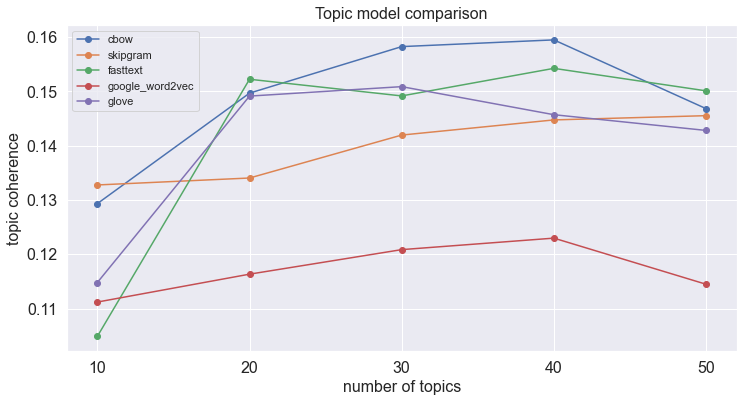

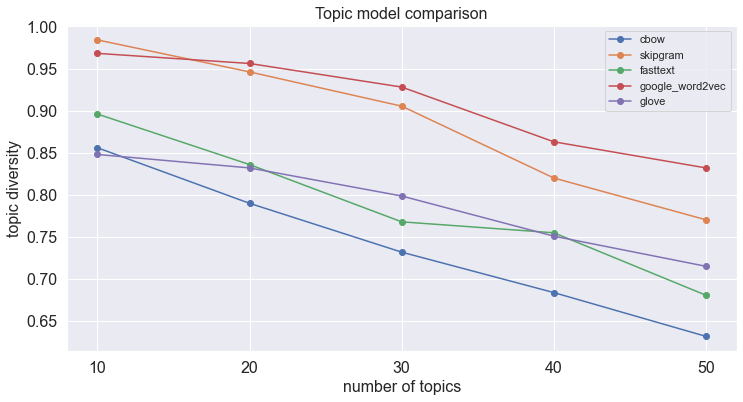

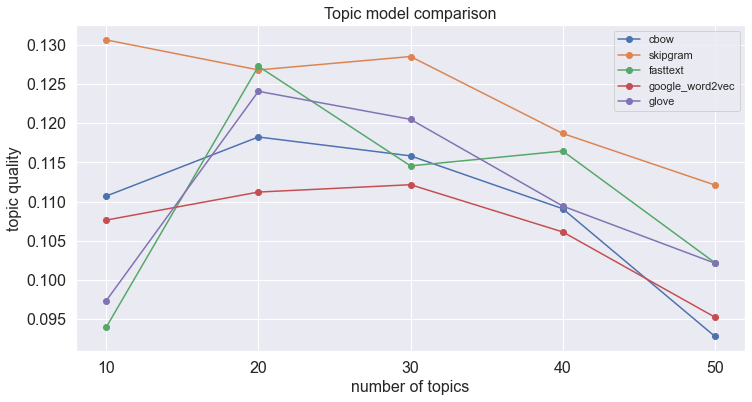

In [28]:
topics_list = [10, 20, 30, 40, 50]
embedding_list = {'cbow': 300, 'skipgram': 300, 'fasttext': 300, 'google_word2vec': 300, 'glove': 300}#, 'random': 300}

etm_tc, etm_td, etm_tq = load_metrics(topics_list, embedding_list, data_path, save_path)
    
display_metric(etm_tc, 'topic coherence')
display_metric(etm_td, 'topic diversity')
display_metric(etm_tq, 'topic quality')

The *topic coherence* graph tends to have an inverted U-shape. This is because of the fact that the *topic coherence*, which measures the coherence of the words in the topics, is low if we consider a too small number of topics (words in the same topic tend to be not semantically similar to one another) as well as a too large one (even words that are semantically similar in the reality tend to be splitted). 
The *topic diversity* graph tends to decrease as the number of topic increases, since the number of repeated words in different topics tends to increase. 
The *topic quality* graph is a metric which incorporates the previous ones, and therefore it shows a mixed behaviour between the two. 

Considering all three metrics, we have that:
- the model with the `cbow` and `fasttext` word embedding turn out to be the best two in terms of *topic coherence* for a number of topics of 30 or 40 and 20 or 50 respectively;
- the model with the `google_word2vec` word embedding turns out to be the best one in terms of *topic diversity*;
- the model with the `skipgram` word embedding turns out to be the best one in terms of *topic quality*.

### 6.ii. Qualitative analysis

We now perform a qualitative analysis on the best model according to *topic quality*, i.e. the *ETM* with 10 topics and skip gram word embeddings.

The *ETM* estimates the following quantities that allows us to extract information from the corpus:
- the document-topic distributions $\theta_1,\ldots,\theta_D$, which are saved as the rows of a $D\times T$ matrix $\theta$;
- the word embeddings $\rho_1,\ldots,\rho_V$, which are saved as the rows of a $V\times E$ matrix $\rho$;
- the topic embeddings $\alpha_1,\ldots,\alpha_T$, which are saved as the rows of a $T\times E$ matrix $\alpha$;
- the topic-word distributions $\beta_1,\ldots,\beta_T$, which are saved as the rows of a $T\times V$ matrix $\beta$,

with $D=6845$ number of documents in the corpus, $E=300$ embedding dimension, $T=10$ number of topics, $V=7370$ number of words in the vocabulary.

In [29]:
model_file = 'ETM_' + data_path.split("/")[-1] + '_skipgram_10_parameters.pt'
best_model = torch.load(save_path + '/' + model_file)

theta = best_model['theta']
alpha = best_model['alpha']
rho = best_model['rho']
beta = best_model['beta']
vocab = best_model['vocab']
num_topics = alpha.shape[0]

First, we explore the compact representation of each document as a mixture of topics, i.e. its document-topic distribution:

In [30]:
interact(visualize_documents, theta=fixed(theta), doc=widgets.IntSlider(min=0,max=theta.shape[0]-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='doc', max=6844), Output()), _dom_classes=('widget-intera…

<function src.qualitative_analysis.visualize_documents(theta, doc)>

The previous representation can be helpful when we are interested in small subsets of documents, however it is unfeasible when we are interested in the whole corpuses made of thousands of documents.
Hence, we consider two approaches to summarize the topic presence in the corpus; in particular, in the first plot we count how many times each topic is the most relevant in a document, i.e. has the highest $\theta_{d,t}$ for $d$ fixed and $t=1,\ldots,T$; in the second plot we count how many times each topic is relevant enough in a document, i.e. its weight $\theta_{d,t}$ is above a certain threshold. As threshold, here we consider the a priori weight that is $\frac{1}{T}=0.1$.

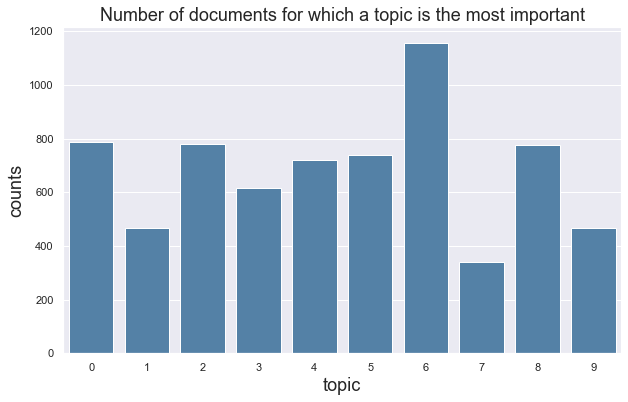

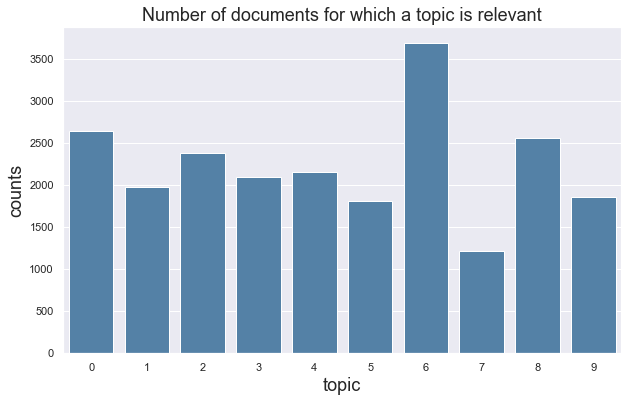

In [31]:
# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS THE MOST RELEVANT
top_topics=list(np.argsort(-1 * theta, axis=1)[:,1])
count_top_topics = list()
for i in range(theta.shape[1]):
    count_top_topics.append((np.array(top_topics)==i).sum(axis=0))
data = {'topic': list(range(theta.shape[1])), 'counts': count_top_topics}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='topic', y='counts', data=df, color='steelblue')
plt.title('Number of documents for which a topic is the most important', fontsize=18)
plt.xlabel('topic', fontsize=18)
plt.ylabel('counts', fontsize=18)
plt.show()

# BARPLOT NUM. DOCUMENTS IN WHICH A TOPIC IS RELEVANT ENOUGH (theta above a threshold)
theta_threshold=1/theta.shape[1]
topic_ndocs=(theta>theta_threshold).sum(axis=0)
data = {'topic': list(range(theta.shape[1])), 'ndocs': list(topic_ndocs)}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x='topic', y='ndocs', data=df, color='steelblue')
plt.title("Number of documents for which a topic is relevant", fontsize=18)
plt.xlabel('topic', fontsize=18)
plt.ylabel('counts', fontsize=18)
plt.show()

According to the graphs the most common topic is 6, followed by 0, 2 and 8; in particular we observe that these topics are the most relevant according to both approaches.

Now, we start considering the parameters on the 300-dimensional embedding space, i.e. $\rho$ and $\alpha$. In order to represent the point of these high-dimensional space, we use *T-SNE*, a nonlinear dimensionality reduction technique that is well suited for embedding high-dimension data into lower dimensional data, which allows us the map the point on a 2-dimensional space.

We represent here the topic embeddings $\alpha$:

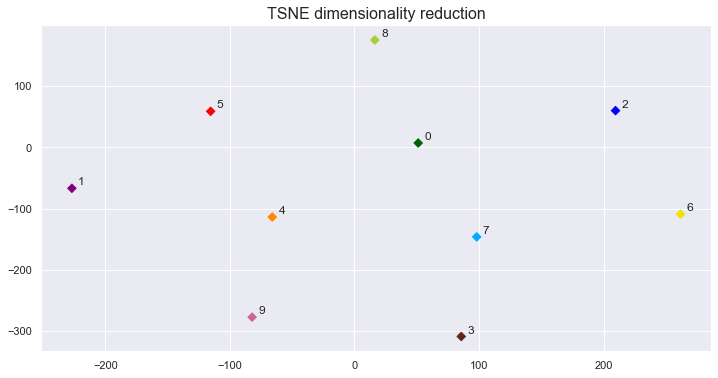

In [32]:
visualize_topics(alpha, colours, annotations=[5,5])

This last plot is not very informative, so we decide to exploit the interpretation of the topics as mixture of words in order to show the topics in a 2-dimensional space without directly using the topic embedding. In particular, for each topic we identify its top 20 words, i.e. the words with highest weight $\beta_{t,v}$, and represent them in the 2-dimensional space generated by the T-SNE:

In [33]:
# tsne
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_words = tsne_model.fit_transform(rho)
# plot
visualize_top_words(tsne_words, beta, rho, colours, alt_colour, topwords=20)

alt.HConcatChart(...)

We observe that top words of a topic tends to be close to each other: this means that the words relevant for a topic are also considered similar by the word embedding model.

Then, we report the top words of each topic in order to show how they are composed: this is useful to identify the theme related to each topic and to give it an interpretation.

In [34]:
interact(barplot_topwords, topic=list((range(num_topics))), beta=fixed(beta), vocab=fixed(vocab), topwords=list((10,15,20)))

interactive(children=(Dropdown(description='topic', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown…

<function src.qualitative_analysis.barplot_topwords(topic, beta, vocab, topwords=10)>

Since we have 10 topics only, we report the interpretation of all of them:
- *topic 0* is about different kinds of energy sources, as we can see with the words *carbon*, *gas*, *coal*, *fuel* and *renewable*, and related terms;
- *topic 1* is about natural landascapes and environments, and their inhabitants such as *species*, *trees*, *fish*;
- *topic 2* is about climate change impacts and academic research on them;
- *topic 3* is about movements and prostests promoted by some group of activists;
- *topic 4* is about government policies and future *plans*;
- *topic 7* is about activities regarding agricolture and food sectors;
- *topic 8* is about *fossil* and *oil* *companies*;
- *topic 9* is about how countries are trying to cohoperate in order to overcome environmental problems.

Finally, we observe that there are two junk topics (5 and 6) whose importance should not be naïvely underestimated by the reader, since their presence allows the model to identify overall better topics (Airoldi et al., 2014).

## 7. Dynamic Embedded Topic Model
The *Dynamic Embedded Topic Model* (*D-ETM*) is a generative model of documents that combines word embeddings and *Dynamic Latent Dirichlet Allocation* (*D-LDA*, Blei & Lafferty, 2006), an extension of *LDA* that uses a probabilistic time series to allow the topics to vary smoothly over time.
Similarly to *D-LDA*, the *D-ETM* involves a probabilistic time series to allow the topics to vary smoothly over time. However, each topic in the *D-ETM* is a time-varying vector on the word embedding space. As in the *ETM*, the probability of each word under the *D-ETM* is a categorical distribution whose natural parameter depends on the inner product between the word’s embedding and a per-topic embedding representation of its assigned topic. In contrast to the *ETM*, the topic embeddings of the *D-ETM* vary over time (Dieng et al., 2019).

Due to computational reasons, we estimate the *D-ETM* only with 10 topics and *skip gram* word embeddings, which are the best combination of number of topics and word embeddings identified for *ETM*.

In [35]:
# number of topics, embeddings
topics, emb_name, emb_size = 10, 'skipgram', 300
# file names
dataset = data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
emb_file = embedding_path + '_' + emb_name + '.txt'
model_file = 'DETM_' + data_path.split("/")[-1] + '_' + emb_name + '_' + str(topics)
# D-ETM        
#main_DETM(dataset=dataset, data_path=data_path, save_path=save_path, emb_file=emb_file, model_file=model_file,
#          rho_size=emb_size, emb_size=emb_size, batch_size=1000, mode='train', num_topics=topics,
#          train_embeddings=0, epochs=400, tc=False)
#main_DETM(dataset=dataset, data_path=data_path, save_path=save_path, emb_file=emb_file, model_file=model_file,
#          load_from=save_path+'/'+model_file,
#          rho_size=emb_size, emb_size=emb_size, batch_size=1000, mode='eval', num_topics=topics,
#          train_embeddings=0, epochs=400, tc=True)

best_model = torch.load(save_path + '/' + model_file + '_parameters.pt')

td = best_model['td']
tc = best_model['tc']
tq = best_model['tq']
alpha = best_model['alpha']
rho = best_model['rho']
beta = best_model['beta']
vocab = best_model['vocab']
num_topics = alpha.shape[0]

print('Topic diversity:', round(np.mean(td), 4))
print('Topic coherence:', round(np.mean(tc), 4))
print('Topic   quality:', round(np.mean(tq), 4))

Topic diversity: 0.9244
Topic coherence: 0.1698
Topic   quality: 0.1569


*D-ETM* outperformed all the <i>ETM</i>s according to both topic diversity, coherence and quality, meaning that, as well as providing a more in-depth analysis of the corpus, *D-ETM* is able to identify better topics than its non-temporal counterpart.

We could perform various qualitative analysis using the estimated parameters, however here we report only one of the most useful features of the model: the possibility of observing how the importance of a word within a topic evolves in the time span considered.

In [36]:
interact(visualize_top_words_evolution, topic=list((range(num_topics))), beta=fixed(beta), vocab=fixed(vocab),
         timestamps=fixed(year_list), topwords=list([5,10,15]))

interactive(children=(Dropdown(description='topic', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown…

<function src.qualitative_analysis.visualize_top_words_evolution(topic, beta, vocab, timestamps, topwords=5)>

## 8. Conclusions

In this work, we studied climate change sensitivity. The set of data under study involved all articles published in the *environment* section of the British newspaper *The Guardian* for the last 10 years. Through the exploratory analysis, we saw that articles are homogeneously distributed across the years; moreover, there are also some words which seem to be relevant almost every year:
- *energy*;
- *emission*;
- *global*;
- *government*.

We developed several <i>ETM</i>s with different number of topics and type of word embeddings, then we performed a quantitative analysis to select the best model according to the metric *topic quality*, and finally a qualitative analysis on the best one was useful to identify the most relevant topics. Moreover, we also estimated a *D-ETM* with the best combination of number of topics and word embeddings identified for *ETM* in order to take into account the wide time range.

The best *ETM* turned out to be the one with 10 topics and *skip gram* fitted on the train set. The main themes which emerge from the qualitative analysis are the world issues related to climate change, energy crisis and international policies to contain the impact of these problems.

Finally, as well as providing a more in-depth analysis of the corpus, *D-ETM* outperformed all the <i>ETM</i>s according to the three metrics considered. Here we focus our attention on *ETM*, however analyzing more in depth *D-ETM* in the same way as we have done for *ETM* could be a way to obtain even better results.

### 8.i. Future work

We could consider a wider variety of word embeddings both fitted on the corpus or pre-trained on much wider corpuses. Here, we did not tune the parameters of *Word2vec* and *FastText*, however we could have optimized various parameters, such as the vector size, the window size, the number of *noise words* of the *negative sampling*, and so on.
As for the pre-trained word embeddings, we could consider the ones made available by *FastText* (see [here](https://fasttext.cc/docs/en/english-vectors.html)) or other versions of *GloVe* (see [here](https://nlp.stanford.edu/projects/glove/)); alternatively, we could consider the approach proposed in Gupta & Jaggi (2021) in which dynamic word embeddings are converted into static ones. Finally, we could also extend the analysis related to *D-ETM*, since here we just scratched the surface, and evaluate more in-depth how the topics evolve.

## References

Airoldi, E. M., Blei, D., Erosheva, E. A., & Fienberg, S. E. (2014). Handbook of Mixed Membership Models and Their Applications. [ACM Digital Library](https://dl.acm.org/doi/book/10.5555/2765552)

Blei, D. M., & Lafferty, J. D. (2006, June). Dynamic topic models. In Proceedings of the 23rd international conference on Machine learning (pp. 113-120). [ACM Digital Library](https://dl.acm.org/doi/10.1145/1143844.1143859)

Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022. [ACM Digital Library](https://dl.acm.org/doi/10.5555/944919.944937)

Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). Enriching word vectors with subword information. Transactions of the association for computational linguistics, 5, 135-146. [MIT Press Direct](https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00051/43387/Enriching-Word-Vectors-with-Subword-Information)

Dieng, A. B., Ruiz, F. J., & Blei, D. M. (2019). The dynamic embedded topic model. arXiv preprint arXiv:[1907.05545](https://arxiv.org/abs/1907.05545).

Dieng, A. B., Ruiz, F. J., & Blei, D. M. (2020). Topic modeling in embedding spaces. Transactions of the Association for Computational Linguistics, 8, 439-453. [ACM Anthology](https://aclanthology.org/2020.tacl-1.29/),  [Arxiv link](https://arxiv.org/abs/1907.04907)

Gupta, P., & Jaggi, M. (2021). Obtaining better static word embeddings using contextual embedding models. arXiv preprint arXiv:[2106.04302](https://arxiv.org/abs/2106.04302).

Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013a). Efficient estimation of word representations in vector space. arXiv preprint arXiv:[1301.3781](https://arxiv.org/abs/1301.3781).

Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013b). Distributed representations of words and phrases and their compositionality. Advances in neural information processing systems, 26. [ACM Digital Library](https://dl.acm.org/doi/abs/10.5555/2999792.2999959)

Pennington, J., Socher, R., & Manning, C. D. (2014, October). Glove: Global vectors for word representation. In Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP) (pp. 1532-1543). [ACL Anthology](https://aclanthology.org/D14-1162/)